# Chromosome 1 analysis

## Loading the data

Import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
from trails.optimizer import trans_emiss_calc, post_prob_wrapper
from trails.read_data import maf_parser
from trails.cutpoints import cutpoints_ABC
from tqdm import tqdm
%load_ext rpy2.ipython

n_int_AB_original = 5
n_int_ABC_original = 5

n_int_AB = 5
n_int_ABC = 5

/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the data:

In [2]:
# Read the output from TRAILS
df = pd.read_csv('../results/chr1_Nelder-Mead_third_run.csv')
# Find iteration with largest likelihood
df = df[df['loglik'] == df['loglik'].max()]
# Convert parameter estimates into dictionary
dct = dict(zip(list(df.columns), df.iloc[0].to_list()))

In [3]:
# Print dictionary
dct

{'n_eval': 136.0,
 't_A': 0.0027561296181322,
 't_B': 0.0029189333873319,
 't_C': 0.0058515616197657,
 't_2': 0.0024428164101813,
 't_upper': 0.0040645452754154,
 'N_AB': 0.0041849972728295,
 'N_ABC': 0.0025322380849019,
 'r': 0.9527482356906288,
 'loglik': -76112897.5348381,
 'time': 413789.77893161774}

The following lines can be used in case we would like to change from certain `n_int_AB` and `n_int_ABC` to another:

In [4]:
cut_ABC_original = cutpoints_ABC(n_int_ABC_original, 1)*dct["N_ABC"]

In [5]:
t_ABC = cut_ABC_original[-2]+dct["t_upper"]
t_ABC

0.00814002525256604

In [6]:
cut_ABC = (cutpoints_ABC(n_int_ABC, 1)*dct["N_ABC"])
cut_ABC_last = cut_ABC[-2]
t_upper = t_ABC-cut_ABC_last
t_upper

0.004064545275415401

In [7]:
t_out = (((dct["t_A"]+dct["t_B"])/2+dct["t_2"])+dct["t_C"])/2 + cut_ABC_original[n_int_ABC_original-1]*dct["N_ABC"] + dct["t_upper"] + 2*dct["N_ABC"]
t_D = (((dct["t_A"]+dct["t_B"])/2+dct["t_2"])+dct["t_C"])/2 + cut_ABC_original[n_int_ABC_original-1]*dct["N_ABC"] + dct["t_upper"]

In [8]:
t_out

0.01470529629717112

## Parameter estimation

First, we can calculate the proportion of ILS from the estimated parameters. We can use the following function:

$\frac{2}{3}\exp\left(-\frac{t_2}{N_\text{AB}}\right)$

Since the units of $t_2$ are number of generations (multiplied by the mutation rate) and the units of $N_\text{AB}$ are number of individuals times two (multiplied by the mutation rate), then we can directly use the formula above:

In [9]:
(2/3)*np.exp(-(dct["t_2"])/(dct["N_AB"]))

0.37188406988327083

We can convert the raw units of the times into number of generations by dividing it by the mutation rate, and into years by then multiplying it by the generation time:

In [10]:
# mu_est_human = 9.70e-09 # Conrad et al., 2011 (human)
# mu_est_human = 1.20e-08 # Kong et al., 2012 (human)
# mu_est_human = 1.20e-08 # Francioli et al., 2015 (human)
# mu_est_human = 1.28e-08 # Rahbari et al., 2016 (human)
# mu_est_human = 1.05e-08 # Wong et al., 2016 (human)
# mu_est_human = 1.29e-08 # Jónsson et al., 2017 (human)
# mu_est_human = 1.28e-08 # Maretty et al., 2017 (human)
# mu_est_human = 1.30e-08 # Turner et al., 2017 (human)
# mu_est_human = 1.10e-08 # Sasani et al., 2019 (human)
# mu_est_human = 1.22e-08 # Kessler et al., 2020 (human)
# mu_est_human = 9.33e-09 # Bergeron et al., 2023 (human)
# mu_est_human = 1.40e-08 # Bergeron et al., 2023 (human)

# mu_est_chimp = 1.20e-8 # Venn et al., 2014 (chimp)
# mu_est_chimp = 1.48e-8 # Tatsumoto et al., 2017 (chimp)
# mu_est_chimp = 1.26e-8 # Besenbacher et al., 2019 (chimp)
# mu_est_chimp = 1.25e-8 # Bergeron et al., 2023 (chimp)

# mu_est_gorilla = 1.13e-08 # Besenbacher et al., 2019 (gorilla)

# mu_est_orangutan = 1.66e-08 # Besenbacher et al., 2019 (orangutan)

mu_est = 1.25e-08
g = 25

df_params = pd.DataFrame()
df_params['Names'] = ['H to HC', 'C to HC', 'G to HCG', 'O to HCGO', 'HC to HCG', 'HCG to HCGO']
df_params['Raw values'] = [dct[i] for i in ['t_A', 't_B', 't_C']] + [t_out-2*dct["N_ABC"], dct['t_2'], cut_ABC_original[n_int_ABC_original-1]*dct["N_ABC"]+dct["t_upper"]]
df_params['Generations (mu = '+str(mu_est)+')'] = [int(i) for i in round(df_params['Raw values']/mu_est)]
df_params['MY (mu = '+str(mu_est)+', g = '+str(g)+')'] = [round(i, 2) for i in df_params['Raw values']/mu_est*25/1000000]
df_params

,Names,Raw values,Generations (mu = 1.25e-08),"MY (mu = 1.25e-08, g = 25)"
0,H to HC,0.002756,220490,5.51
1,C to HC,0.002919,233515,5.84
2,G to HCG,0.005852,468125,11.70
3,O to HCGO,0.009641,771266,19.28
4,HC to HCG,0.002443,195425,4.89
5,HCG to HCGO,0.004075,325989,8.15


In [11]:
# 2–3% Moorjani et al., 2016
(dct['t_B']/dct['t_A']-1)*100 

5.906970707351222

In [12]:
# 6–7% Moorjani et al., 2016
(dct['t_C']/(dct['t_A']+dct['t_2'])-1)*100 

12.552844132215446

In [13]:
# 11% Moorjani et al., 2016
(t_D/(dct['t_A']+dct['t_2']+cut_ABC_original[n_int_ABC_original-1]*dct["N_ABC"]+dct["t_upper"])-1)*100

3.9574746845492115

We can also convert the effective population sizes into diploid population size by dividing by 2 times the mutation rate:

In [14]:
# 177368 (HC) Rivas-González et al., 2023
# 106702 (HCG) Rivas-González et al., 2023

df_params = pd.DataFrame()
df_params['Names'] = ['HC', 'HCG']
df_params['Raw values'] = [dct[i] for i in ['N_AB', 'N_ABC']]
df_params['2N (mu = '+str(mu_est)+')'] = [int(i) for i in round(df_params['Raw values']/mu_est)]
df_params['N (mu = '+str(mu_est)+')'] = [int(i) for i in round(df_params['Raw values']/mu_est/2)]
df_params

,Names,Raw values,2N (mu = 1.25e-08),N (mu = 1.25e-08)
0,HC,0.004185,334800,167400
1,HCG,0.002532,202579,101290


Finally, the recombination rate can be calculated by multiplying the raw value by the mutation rate:

In [15]:
df_params = pd.DataFrame()
df_params['Names'] = ['Recombination']
df_params['Raw value'] = [dct[i] for i in ['r']]
df_params['r (mu = '+str(mu_est)+')'] = df_params['Raw value']*mu_est
df_params

,Names,Raw value,r (mu = 1.25e-08)
0,Recombination,0.952748,1.190935e-08


## Posterior decoding

Based on the estimated values, we can compute the transition and emission probabilities of the TRAILS model:

In [16]:
if 'a' not in globals():
    a, b, pi, hidden_names, observed_names = trans_emiss_calc(
        dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, t_out, 
        dct["N_AB"], dct["N_ABC"], dct["r"], n_int_AB, n_int_ABC)

2023-06-07 11:36:56,714	INFO worker.py:1625 -- Started a local Ray instance.


We can then parse the chr1 region using the TRAILS maf parser:

In [17]:
if 'obs' not in globals():
    obs = maf_parser('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

To calculate the posterior probabilities, we can use the `post_prob_wrapper` function:

In [ ]:
if 'post_prob' not in globals():
    post_prob = post_prob_wrapper(a, b, pi, obs)

In [21]:
len(post_prob)

(raylet) [2023-06-07 11:33:56,937 E 4934 727828] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-07_11-17-02_483412_4604 is over 95% full, available space: 17498882048; capacity: 499963174912. Object creation will fail if spilling is required.


NameError: name 'post_prob' is not defined

(raylet) [2023-06-07 11:34:06,997 E 4934 727828] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-07_11-17-02_483412_4604 is over 95% full, available space: 17498505216; capacity: 499963174912. Object creation will fail if spilling is required.


The following function is used to extract the sequence and position information from the maf alignment:

In [18]:
from Bio import AlignIO

def maf_seq(file, sp_lst):
    total_dct = {sp_lst[0]:[], sp_lst[1]:[], sp_lst[2]:[], sp_lst[3]:[]}
    start_dct = []
    # Start loglik accumulator
    loglik_acc = 0
    # For each block
    for multiple_alignment in AlignIO.parse(file, "maf"):
        # Save sequence
        dct = {}
        # For each sequence in the alignment block
        for seqrec in multiple_alignment:
            if seqrec.name.split('.')[0] in sp_lst:
                # Save nucleotides as ones and gaps as zeros
                dct[seqrec.name.split('.')[0]] = ''.join([str(int(j!='-')) for j in str(seqrec.seq)])
            if seqrec.name.split('.')[0] == 'hg38':
                # Save the start position of the block in human coordinates
                start = seqrec.annotations['start']
        # Append information to list
        if len(dct) == 4: 
            start_dct.append(start)
            for i in sp_lst:
                total_dct[i].append(dct[i])
    return total_dct, start_dct

# Get sequence and start information
seqinfo, startinfo = maf_seq('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

Now, we will iterate over the alignment blocks, save the position in human coordinates, and mark gaps as -9:

In [19]:
tot_lst = []
# For each block
for i in range(len(startinfo)):
    # Save start coordinate
    st = startinfo[i]
    tmp_lst = []
    # For each site in the human sequence
    for j in seqinfo['hg38'][i]:
        # If the site is not a gap
        if j == '1':
            # Append position
            tmp_lst.append(st)
            # Update coordinate
            st += 1
        # If it is a gap
        else:
            # Append -9
            tmp_lst.append(-9)
    tot_lst.append(tmp_lst)

In order to summarize the data, we will calculate the mean posterior probability in 100 kb windows for each of the hidden states:

In [195]:
# Define bin size
binsize = 100000

In [22]:
# Create empty data frame
summary = pd.DataFrame()
# For each block
for j in tqdm(range(len(post_prob))):
    # Convert posteriors into data frame
    dat = pd.DataFrame(post_prob[j])
    # Add hidden states as column names
    dat.columns = [str(i) for i in list(hidden_names.values())]
    # Add position in human coordinates
    dat['position'] = tot_lst[j]
    # Filter gaps
    dat = dat[dat['position'] != -9]
    # Bin the result using the bin size
    dat['bin'] = dat['position'] // binsize
    # Calculate number of sites per bin
    t1 = dat.groupby('bin').agg(size=('(0, 0, 0)', 'size')).reset_index()
    # Calculate mean posterior probability per hidden state
    t2 = dat.groupby('bin').agg('mean').reset_index()
    # Append to overall result
    summary = pd.concat([summary, t1.merge(t2)])

100%|██████████| 2599/2599 [08:05<00:00,  5.36it/s]  


In [23]:
# from tqdm import tqdm
# 
# # Create empty data frame
# ILS_summary = {0:0, 1:0, 2:0, 3:0}
# # For each block
# for j in tqdm(range(len(post_prob))):
#     # Convert posteriors into data frame
#     dat = pd.DataFrame(post_prob[j])
#     # Add hidden states as column names
#     dat.columns = [str(i) for i in list(hidden_names.values())]
#     # Add position in human coordinates
#     dat['position'] = tot_lst[j]
#     # Filter gaps
#     dat = dat[dat['position'] != -9]
#     dat = dat.melt(id_vars=['position'], value_vars=dat.columns[:-1])
#     dat = dat[dat.groupby('position')['value'].transform(max) == dat['value']] 
#     dat['V'] = [int(i[1]) for i in dat['variable']]
#     dat = dat.groupby('V').size().to_dict()
#     for i in range(4):
#         ILS_summary[i] += dat.get(i, 0)
# ILS_summary

In [24]:
# ILS_summary = {0: 15397599, 1: 11431336, 2: 9264987, 3: 9227896}
# (ILS_summary[2]+ILS_summary[3])/np.array(list(ILS_summary.values())).sum()
# 0.40803488950950734

In [25]:
binsize = 100000

In [26]:
%%R -i summary

library(tidyverse)

summary %>% write_csv('../data/summary.csv')

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



We can import the data frame into R for plotting:

In [191]:
%%R

library(tidyverse)

# summary %>% write_csv('../data/summary.csv')

summary <- read_csv('../data/summary.csv')

totab <- summary %>%
    # Convert to tibble
    as_tibble() %>%
    # Remove unused columns
    select(-position) %>%
    # Pivot table
    pivot_longer(-c(bin, size)) %>%
    # For each bin and hidden state
    group_by(bin, name) %>%
    summarize(
        # Calculate the mean posterior weighted by 
        # the number of sites
        value = weighted.mean(value, size),
        size = sum(size)
    ) %>%
    # Convert hidden state names into plottable info
    mutate(
        name = str_remove_all(name, '\\('),
        name = str_remove_all(name, '\\)')
    ) %>%
    separate(name, c('V', 't1', 't2'), ', ') %>%
    mutate(
        V = as.integer(V),
        t1 = as.integer(t1),
        t2 = as.integer(t2),
        is_V0 = V == 0
    ) 
totab 

Rows: 3053 Columns: 73
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (73): bin, size, (0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.
# A tibble: 35,140 × 7
# Groups:   bin [502]
     bin     V    t1    t2   value  size is_V0
   <dbl> <int> <int> <int>   <dbl> <dbl> <lgl>
 1   249     0     0     0 0.0200   1485 TRUE 
 2   249     0     0     1 0.0174   1485 TRUE 
 3   249     0     0     2 0.0149   1485 TRUE 
 4   249     0     0     3 0.0124   1485 TRUE 
 5   249     0     0     4 0.00929  1485 TRUE 
 6   249     0     1     0 0.0212   1485 TRUE 
 7   249     0     1     1 0.0184   1485 TRUE 
 8   249     0     1     2 0.0158   1485 TRUE 
 9   249     0     1     3 0.0132   1485 

In [192]:
%%R

totab %>%
    group_by(bin, V) %>%
    summarize(
        value = sum(value),
        n = unique(size)
    ) %>% pivot_wider(names_from = V, values_from = value) %>%
    mutate(
        ILS = `2`+`3`
    ) %>%
    ungroup() %>%
    summarize(ILS = weighted.mean(ILS, n))

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.
# A tibble: 1 × 1
    ILS
  <dbl>
1 0.347


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


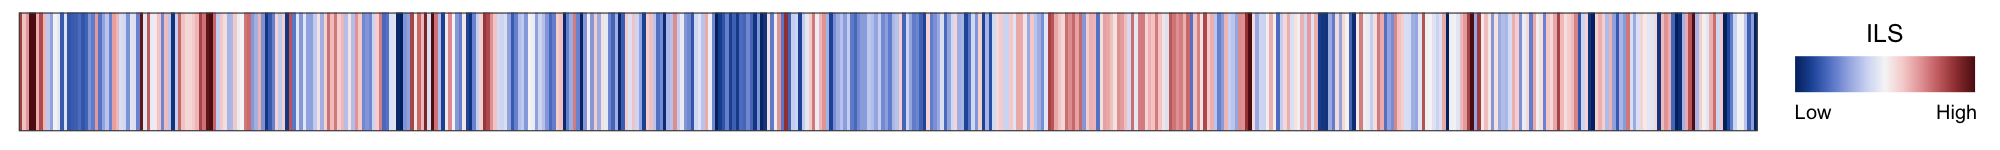

In [210]:
%%R -w 2000 -h 150 -r 150 -i binsize

# Load packages
library(ggHoriPlot)
library(ggthemes)

tab_ILS <- totab %>%
    # Group by bin and topology
    group_by(bin, V) %>%
    # Sum the mean posterior
    summarize(
        value = sum(value)
    ) %>%
    # Group only by bin
    group_by(bin) %>%
    # Calculate ILS proxy from the mean posterior
    summarize(
        ILS = sum(value[V %in% c(2, 3)])/sum(value)
    ) %>%
    # Convert bins into coordinates
    mutate(bin = bin*binsize/1000000) %>%
    ungroup() %>%
    mutate(
        ILS = case_when(
            ILS <= quantile(ILS, 0.01) ~ min(ILS[ILS > quantile(ILS, 0.01)]),
            ILS >= quantile(ILS, 0.99) ~ max(ILS[ILS < quantile(ILS, 0.99)]),
            TRUE ~ ILS
        )
    )
    
p_ILS <- tab_ILS %>%
    # Plot as horizon plot
    ggplot() +
    geom_tile(aes(x = bin, y = 0, fill=ILS)) +
    theme_few() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        legend.direction="horizontal",
        text = element_text(size = 12),
        #legend.text = element_blank()
         ) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0)) +
    colorspace::scale_fill_continuous_diverging(
        name = 'ILS',
        palette = "Blue-Red 3", mid = (max(tab_ILS$ILS)+min(tab_ILS$ILS))/2,
        breaks = c(min(tab_ILS$ILS)+(max(tab_ILS$ILS)-min(tab_ILS$ILS))*0.1, 
                   min(tab_ILS$ILS)+(max(tab_ILS$ILS)-min(tab_ILS$ILS))*0.9),
        labels = c('Low', 'High')) + 
    guides(fill=guide_colorbar(ticks.colour = NA, title.position="top", title.hjust = 0.5))
p_ILS

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


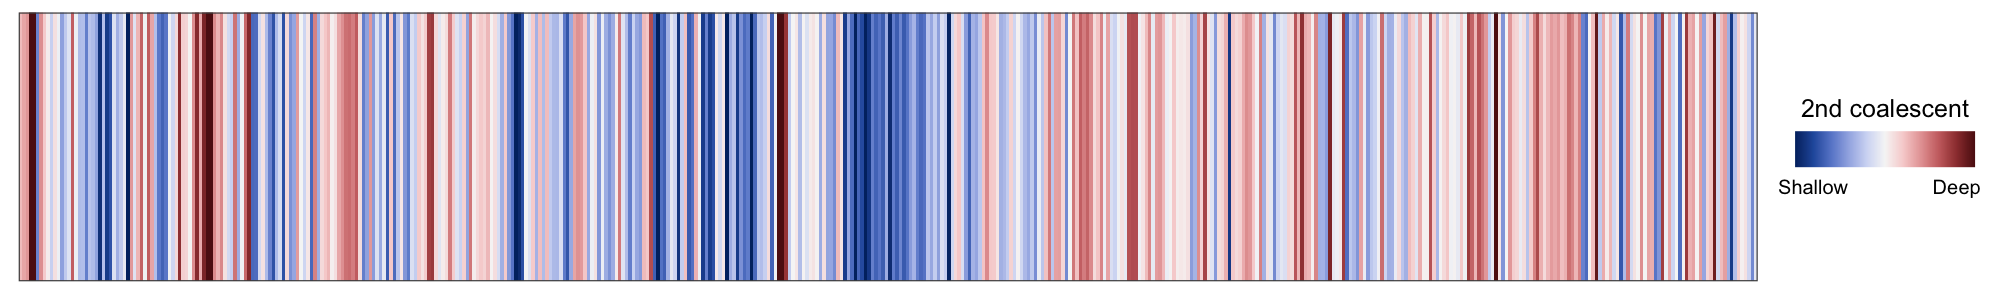

In [211]:
%%R -w 2000 -h 300 -r 150

# This is similar to the previous block, 
# but for the second coalescent
tab_t2 <- totab %>%
    group_by(bin, t2) %>%
    summarize(
        value = sum(value)
    ) %>%
    group_by(bin) %>%
    summarize(t2 = weighted.mean(t2, value)) %>%
    mutate(bin = bin*binsize/1000000) %>%
    ungroup() %>%
    mutate(
        t2 = case_when(
            t2 <= quantile(t2, 0.01) ~ min(t2[t2 > quantile(t2, 0.01)]),
            t2 >= quantile(t2, 0.99) ~ max(t2[t2 < quantile(t2, 0.99)]),
            TRUE ~ t2
        )
    )
    
p_t2 <- tab_t2 %>%
    ggplot() +
    geom_tile(aes(x = bin, y = 0, fill=t2)) +
    theme_few() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        legend.direction="horizontal",
        text = element_text(size = 12),
        # legend.text = element_blank()
         )  +
    xlab('Position (Mb)') +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0)) +
    colorspace::scale_fill_continuous_diverging(
        name = '2nd coalescent',
        palette = "Blue-Red 3", mid = (max(tab_t2$t2)+min(tab_t2$t2))/2,
        breaks = c(min(tab_t2$t2)+(max(tab_t2$t2)-min(tab_t2$t2))*0.1, 
                   min(tab_t2$t2)+(max(tab_t2$t2)-min(tab_t2$t2))*0.9),
        labels = c('Shallow', 'Deep')) + 
    guides(fill=guide_colorbar(ticks.colour = NA, title.position="top", title.hjust = 0.5))

    p_t2

`summarise()` has grouped output by 'bin', 't1'. You can override using the
`.groups` argument.


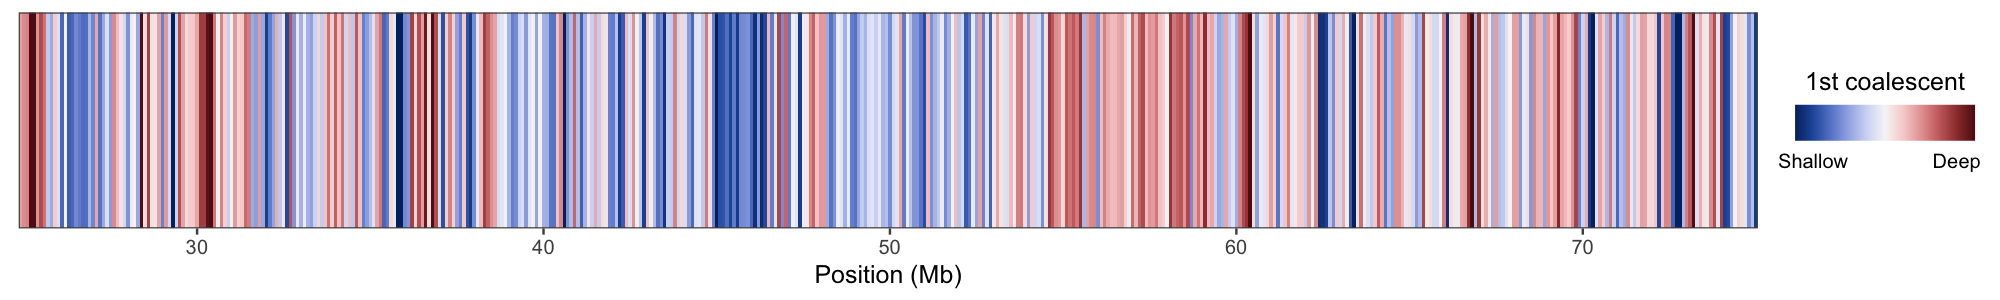

In [212]:
%%R -w 2000 -h 300 -r 150 -i n_int_AB

# This is similar to the previous block, 
# but for the first coalescent
tab_t1 <- totab %>%
    group_by(bin, t1, is_V0) %>%
    summarize(
        value = sum(value)
    ) %>%
    ungroup() %>%
    mutate(
        t1 = ifelse(!is_V0, t1+n_int_AB, t1)
    ) %>%
    group_by(bin) %>%
    summarize(t1 = weighted.mean(t1, value)) %>%
    mutate(bin = bin*binsize/1000000) %>%
    mutate(
        t1 = case_when(
            t1 <= quantile(t1, 0.01) ~ min(t1[t1 > quantile(t1, 0.01)]),
            t1 >= quantile(t1, 0.99) ~ max(t1[t1 < quantile(t1, 0.99)]),
            TRUE ~ t1
        )
    )
    
p_t1 <- tab_t1 %>%
    ggplot() +
    geom_tile(aes(x = bin, y = 0, fill=t1)) +
    theme_few() +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        legend.direction="horizontal",
        text = element_text(size = 12)
        # legend.text = element_blank()
    ) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0)) +
    xlab('Position (Mb)') +
    colorspace::scale_fill_continuous_diverging(
        name = '1st coalescent',
        palette = "Blue-Red 3", mid = (max(tab_t1$t1)+min(tab_t1$t1))/2,
        breaks = c(min(tab_t1$t1)+(max(tab_t1$t1)-min(tab_t1$t1))*0.1, 
                   min(tab_t1$t1)+(max(tab_t1$t1)-min(tab_t1$t1))*0.9),
        labels = c('Shallow', 'Deep')
    ) + 
    guides(fill=guide_colorbar(ticks.colour = NA, title.position="top", title.hjust = 0.5))

p_t1

In [213]:
%%R -w 2000 -h 600 -r 150

library(patchwork)

p_ILS / p_t2 / p_t1 & theme(plot.margin = unit(c(0,0,0,0), "cm"), legend.position = 'none')

ggsave('../plots/heatmap_chr1.pdf', height = 3/1.5, width = 12/1.5)

In [33]:
%%R

full_join(full_join(tab_ILS, tab_t1, by = 'bin'), tab_t2, by = 'bin') %>%
    summarize(
        ILS_t1 = cor(ILS, t1),
        ILS_t2 = cor(ILS, t2),
        t1_t2 = cor(t1, t2)
    ) 

# A tibble: 1 × 3
  ILS_t1 ILS_t2 t1_t2
   <dbl>  <dbl> <dbl>
1  0.979  0.483 0.501


In [65]:
%%R

248387328
25000000
75000000

ggplot() +
    geom_rect(aes(xmin = 0, xmax = 248387328, ymin = 0, ymax = 1)) +
    geom_vline(aes(xintercept = x), data = tibble(x = c(25000000, 75000000))) +
    geom_point(aes(x = 123400000, y = 0.5)) +
    theme_void()
    
ggsave('../plots/chr1_location.pdf', width = 16, height = 2)

## Posterior decoding at the base-pair level

In [9]:
obs = maf_parser('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

In [10]:
from Bio import AlignIO

def maf_seq(file, sp_lst):
    total_dct = {sp_lst[0]:[], sp_lst[1]:[], sp_lst[2]:[], sp_lst[3]:[]}
    start_dct = []
    # Start loglik accumulator
    loglik_acc = 0
    # For each block
    for multiple_alignment in AlignIO.parse(file, "maf"):
        # Save sequence
        dct = {}
        # For each sequence in the alignment block
        for seqrec in multiple_alignment:
            if seqrec.name.split('.')[0] in sp_lst:
                # Save nucleotides as ones and gaps as zeros
                dct[seqrec.name.split('.')[0]] = ''.join([str(int(j!='-')) for j in str(seqrec.seq)])
            if seqrec.name.split('.')[0] == 'hg38':
                # Save the start position of the block in human coordinates
                start = seqrec.annotations['start']
        # Append information to list
        if len(dct) == 4: 
            start_dct.append(start)
            for i in sp_lst:
                total_dct[i].append(dct[i])
    return total_dct, start_dct

# Get sequence and start information
seqinfo, startinfo = maf_seq('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

Now, we will iterate over the alignment blocks, save the position in human coordinates, and mark gaps as -9:

In [11]:
tot_lst = []
# For each block
for i in range(len(startinfo)):
    # Save start coordinate
    st = startinfo[i]
    tmp_lst = []
    # For each site in the human sequence
    for j in seqinfo['hg38'][i]:
        # If the site is not a gap
        if j == '1':
            # Append position
            tmp_lst.append(st)
            # Update coordinate
            st += 1
        # If it is a gap
        else:
            # Append -9
            tmp_lst.append(-9)
    tot_lst.append(tmp_lst)

In [9]:
t_2 = dct['t_2']
N_AB = dct['N_AB']

In [10]:
cut_ABC_new = cutpoints_ABC(n_int_ABC, 3)
a_1, b_1, pi_1, hidden_names_1, observed_names_1 = trans_emiss_calc(
        dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, t_out, 
        dct["N_AB"], dct["N_ABC"], dct["r"], n_int_AB, n_int_ABC,
        cut_AB = 'standard', cut_ABC = cut_ABC_new)

2023-06-12 11:37:39,044	INFO worker.py:1625 -- Started a local Ray instance.


KeyboardInterrupt: 

(raylet) [2023-06-12 11:37:48,023 E 92350 14106646] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-12_11-37-35_788507_89999 is over 95% full, available space: 22650896384; capacity: 499963174912. Object creation will fail if spilling is required.


In [14]:
%%R -i t_2 -i N_AB -i n_int_ABC -o quant

library(PhaseTypeR)
library(tidyverse)

subint_mat <- matrix(
    c(
        c(-1, 0, 0),
        c(0, -3, 3),
        c(0, 0, -1)
    ),
    nrow = 3,
    byrow = T
)
init_probs <- c(1-exp(-t_2/N_AB), exp(-t_2/N_AB), 0)
ph_obj <- PH(subint_mat, init_probs)

quant <- qPH(seq(0, 1, length.out = n_int_ABC+1), ph_obj)
quant <- c(quant[1:(length(quant)-1)], Inf)
quant

R[write to console]: 
Attaching package: ‘PhaseTypeR’


R[write to console]: The following object is masked from ‘package:stats’:

    var


(raylet) [2023-06-12 10:35:34,592 E 97880 13696925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-12_10-32-28_913470_84342 is over 95% full, available space: 21553405952; capacity: 499963174912. Object creation will fail if spilling is required.


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
[1] 0.0000000 0.3559713 0.7017772 1.1397056 1.8500675       Inf


In [15]:
a_2, b_2, pi_2, hidden_names_2, observed_names_2 = trans_emiss_calc(
        dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, t_out, 
        dct["N_AB"], dct["N_ABC"], dct["r"], n_int_AB, n_int_ABC,
        cut_AB = 'standard', cut_ABC = quant)

/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
(raylet) [2023-06-12 10:35:44,656 E 97880 13696925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-12_10-32-28_913470_84342 is over 95% full, available space: 21542113280; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2023-06-12 10:35:54,722 E 97880 13696925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-12_10-32-28_913470_84342 is over 95% full, available space: 20467826688; capacity: 499963174912. Object creation will fail if spilling is required.
(raylet) [2023-06-12 10:36:04,791 E 97880 13696925] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-06-12_10-32-28_913470_84342 is over 95% full, available space: 20467798016; capacity: 499963174912. O

In [16]:
import ray

ray.shutdown()

In [17]:
ranges = []
st = 0
sites = 0
threshold = 200000
for i in range(len(tot_lst)):
    sites += len(tot_lst[i])
    if sites > threshold:
        ranges.append((st, i))
        st = i+1
        sites = 0
len(ranges)

211

In [18]:
num = 54000000
idx_search = [tot_lst[i[0]][0] for i in ranges]
idx = min(range(len(idx_search)), key=lambda x:abs(idx_search[x]-num))
idx

121

In [19]:
flat_list = [item for sublist in tot_lst[ranges[idx][0]:(ranges[idx][1]+1)] for item in sublist]
print((flat_list[0], flat_list[len(flat_list)-1]))

(54026492, 54284458)


In [20]:
# idx = 22

import os

import random
random.seed(10)
my_list = list(range(len(ranges)))
random.shuffle(my_list)

for idx in my_list:
# for idx in [194]:

    if os.path.isfile(f'tmp/tmp_{idx}.pdf'):
        continue

    print(idx)

    flat_list = [item for sublist in tot_lst[ranges[idx][0]:(ranges[idx][1]+1)] for item in sublist]
    print((flat_list[0], flat_list[len(flat_list)-1]))
    
    post_prob_subset = post_prob_wrapper(a_1, b_1, pi_1, obs[ranges[idx][0]:(ranges[idx][1]+1)])
    post_prob_subset_df = pd.DataFrame(np.concatenate(post_prob_subset))
    post_prob_subset_df.rename(columns=hidden_names_1, inplace=True)
    post_prob_subset_df.columns = [str(f'{i[0]}, {i[1]}, {i[2]}') for i in post_prob_subset_df.columns]
    post_prob_subset_df['position'] = flat_list
    post_prob_subset_df.to_csv(f'tmp/test_{idx}_p1.csv', index = False)

    post_prob_subset = post_prob_wrapper(a_2, b_2, pi_2, obs[ranges[idx][0]:(ranges[idx][1]+1)])
    post_prob_subset_df = pd.DataFrame(np.concatenate(post_prob_subset))
    post_prob_subset_df.rename(columns=hidden_names_2, inplace=True)
    post_prob_subset_df.columns = [str(f'{i[0]}, {i[1]}, {i[2]}') for i in post_prob_subset_df.columns]
    post_prob_subset_df['position'] = flat_list
    post_prob_subset_df.to_csv(f'tmp/test_{idx}_p2.csv', index = False)

    !Rscript save_plot.r {idx}

    os.remove(f'tmp/test_{idx}_p1.csv')
    os.remove(f'tmp/test_{idx}_p2.csv')

In [12]:
%%R -i n_int_AB -i n_int_ABC

library(tidyverse)
library(ggrastr)
library(ggthemes)
library(patchwork)

# for (idx in 0:211) {

for (idx in c(120)) {

    # if (file.exists(paste0('./tmp/tmp_', idx, '.pdf'))) {
    #     next
    # }

    print(idx)

    df_p1 <- read_csv(paste0('tmp/test_', idx, '_p1.csv')) 
    
    df_mod_p1 <- df_p1 %>%
        filter(position != -9) %>%
        pivot_longer(-position) %>%
        separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
        mutate(
            topology = as.integer(topology),
            int_1 = as.integer(int_1),
            int_2 = as.integer(int_2),
            is_V0 = topology == 0
        )

    df_p2 <- read_csv(paste0('tmp/test_', idx, '_p2.csv'))
    
    df_mod_p2 <- df_p2 %>%
        filter(position != -9) %>%
        pivot_longer(-position) %>%
        separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
        mutate(
            topology = as.integer(topology),
            int_1 = as.integer(int_1),
            int_2 = as.integer(int_2),
            is_V0 = topology == 0
        )
        
    p1 <- df_mod_p1 %>%
        group_by(position, is_V0, int_1) %>%
        summarize(prob = sum(value)) %>%
        ggplot() +
        rasterize(geom_tile(aes(position, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)), dpi = 300) +
        geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
        theme_few() +
        scale_fill_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno"
                            ) +
        scale_color_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno"
                             ) +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(
            breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))), 
            # labels = c(0:(n_int_AB-1), 0:(n_int_ABC_1-1)),
            labels = paste0('F', c(0:(n_int_AB+n_int_ABC-1))),
            expand = c(0, 0),
            sec.axis = dup_axis(
                # breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC_1)))-0.5,
                # labels = sprintf("%.0f", round(c(cut_AB[0:(length(cut_AB)-1)], cut_ABC_new)))
                # labels = rep('', length(round(c(cut_AB[0:(length(cut_AB)-1)], cut_ABC_new))))
            )
        ) +
        theme(
            axis.title.y.right = element_blank()
        ) +
        labs(y = 'First coalescent', x = 'Position')
    
    p2 <- df_mod_p2 %>%
        group_by(position, int_2) %>%
        summarize(prob = sum(value)) %>%
        ggplot() +
        rasterize(geom_tile(aes(position, int_2, fill = prob, color = prob)), dpi = 300) +
        theme_few() +
        scale_fill_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno") +
        scale_color_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno") +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(
            breaks = 0:(n_int_ABC-1), 
            # labels = 0:(n_int_ABC_2-1),
            labels = paste0('S', 0:(n_int_ABC-1)),
            expand = c(0, 0),
            sec.axis = dup_axis(
                # breaks = (0:n_int_ABC_2)-0.5,
                # labels = sprintf("%.0f", round(cut_ABC))
                # breaks = seq(-0.5, n_int_ABC_2-0.5, 0.5),
                # labels = c(rbind(rep('', length(cut_ABC)-1), paste0('S', 0:(n_int_ABC_2-1))), '')
            )
        ) +
        labs(y = 'Second coalescent') +
        theme(
            axis.title.x = element_blank(),
            axis.text.x = element_blank(),
            axis.ticks.x=element_blank(),
            axis.title.y.right = element_blank()
        )
    
    p3 <- df_mod_p1 %>%
        group_by(position, topology) %>%
        summarize(prob = sum(value)) %>%
        ggplot() +
        rasterize(geom_tile(aes(position, topology, fill = prob, color = prob)), dpi = 300) +
        theme_few() +
        scale_fill_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno") +
        scale_color_viridis_c(name = 'Posterior\nprobability', 
                             limits = c(0, 1),
                             option="inferno") +
        scale_x_continuous(expand = c(0, 0)) +
        scale_y_continuous(
            breaks = c(0, 1, 2, 3), 
            labels = c('V0', 'V1', 'V2', 'V3'),
            expand = c(0, 0),
            sec.axis = dup_axis()
        ) +
        labs(y = 'Topology') +
        theme(
            axis.title.x = element_blank(),
            axis.text.x = element_blank(),
            axis.ticks.x=element_blank(),
            axis.title.y.right = element_blank()
        )
    
    fac <- 0.7 
    
    plt_tot <- (p3+p2+p1 + 
      plot_layout(ncol = 1, heights = c(4, n_int_ABC, n_int_AB+n_int_ABC), guides = 'collect')) & theme(legend.position = 'none')
    
    ggsave(paste0('./tmp/tmp_', idx, '.pdf'), plt_tot, 
           width = 14*fac, height = 9*fac)

}

[1] 120
Rows: 212758 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 212758 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'position', 'is_V0'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.grou

In [218]:
%%R -w 2000 -h 300 -r 150

idx = 120

print(idx)

df_p1 <- read_csv(paste0('tmp/test_', idx, '_p1.csv')) 

df_mod_p1 <- df_p1 %>%
    filter(position != -9) %>%
    filter(position > 53985000) %>%
    pivot_longer(-position) %>%
    separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
    mutate(
        topology = as.integer(topology),
        int_1 = as.integer(int_1),
        int_2 = as.integer(int_2),
        is_V0 = topology == 0
    )

df_p2 <- read_csv(paste0('tmp/test_', idx, '_p2.csv'))

df_mod_p2 <- df_p2 %>%
    filter(position != -9) %>%
    filter(position > 53985000) %>%
    pivot_longer(-position) %>%
    separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
    mutate(
        topology = as.integer(topology),
        int_1 = as.integer(int_1),
        int_2 = as.integer(int_2),
        is_V0 = topology == 0
    )
    
p1 <- df_mod_p1 %>%
    group_by(position, is_V0, int_1) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)) +
    geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno"
                            ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))), 
        # labels = c(0:(n_int_AB-1), 0:(n_int_ABC_1-1)),
        labels = paste0('F', c(0:(n_int_AB+n_int_ABC-1))),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    theme(
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    ) +
    labs(y = 'First coalescent', x = 'Position')

p2 <- df_mod_p2 %>%
    group_by(position, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, int_2, fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, int_2, fill = prob, color = prob)) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = 0:(n_int_ABC-1), 
        # labels = 0:(n_int_ABC_2-1),
        labels = paste0('S', 0:(n_int_ABC-1)),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    labs(y = 'Second coalescent') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    )

p3 <- df_mod_p1 %>%
    group_by(position, topology) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, topology, fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, topology, fill = prob, color = prob)) +
    # geom_vline(aes(xintercept = x), color = 'green', data = tibble(x = c(54002500, 54009300))) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0, 1, 2, 3), 
        labels = c('V0', 'V1', 'V2', 'V3'),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    labs(y = 'Topology') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    )








limits <- c(min(df_mod_p1$position), max(df_mod_p1$position))

tr_tab <- read_tsv('./tmp/table_120.tsv',
    col_types = c('ccciiiiicccc')
) 

colnames(tr_tab) <- str_remove_all(colnames(tr_tab), 'hg38.knownGene.')
    
exon_tab <- tr_tab %>%
    group_by(`#name`, chrom, strand, txStart,  txEnd, cdsStart, cdsEnd, exonCount, proteinID, alignID) %>%
    summarize(
        exonStarts = unlist(str_split(exonStarts, ',')),
        exonEnds = unlist(str_split(exonEnds, ','))
    ) %>%
    filter(exonStarts != '') %>%
    mutate(
        exonStarts = as.integer(exonStarts),
        exonEnds = as.integer(exonEnds)
    )

reg_tab_1 <- exon_tab %>%
    filter(exonStarts == min(exonStarts))
reg_tab_2 <- exon_tab %>%
    filter(exonStarts == max(exonStarts))

exon_tab <- exon_tab %>%
    mutate(
        exonStarts = ifelse(exonStarts == min(exonStarts), cdsStart, exonStarts)
    )

p_genes <- exon_tab %>%
    ggplot() +
    geom_segment(aes(x = cdsStart, xend = cdsEnd, y = 0.5, yend = 0.5)) +
    geom_rect(aes(xmin = exonStarts, xmax = exonEnds, ymin = 0, ymax = 1), color = 'black', fill = 'black') +
    geom_rect(aes(xmin = exonStarts, xmax = cdsStart, ymin = 0, ymax = 1), color = 'black', fill = 'white', data = reg_tab_1) +
    geom_rect(aes(xmin = exonEnds, xmax = cdsEnd, ymin = 0, ymax = 1), color = 'black', fill = 'white', data = reg_tab_2) +
    scale_x_continuous(limits = limits, expand = c(0, 0)) +
    scale_y_continuous(limits = c(0, 1.6)) +
    geom_segment(aes(x = exonEnds, xend = exonEnds-2000, y = 1.3, yend = 1.3), arrow = arrow(length = unit(0.3, "npc")), data = reg_tab_2) +
    geom_segment(aes(x = exonEnds, xend = exonEnds, y = 1, yend = 1.3), data = reg_tab_2) +
    geom_text(aes(x = exonEnds+300, y = 0.5, label = "italic('LDLRAD1')"), parse = TRUE, size = 3, hjust = 0, data = reg_tab_2) +
    theme_void()


# LDLRAD1


fac = 0.7


plt_tot <- (p_genes+p3+p2+p1 + 
      plot_layout(ncol = 1, heights = c(1, 4, n_int_ABC, n_int_AB+n_int_ABC), guides = 'collect')) & theme(legend.position = 'none')
    
ggsave(paste0('./tmp/tmp_', idx, '_region_with_genes.tiff'), plt_tot, width = 12*fac, height = 10*fac)


[1] 120
Rows: 212758 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 212758 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'position', 'is_V0'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.grou

In [189]:
%%R

limits

[1] 53985001 54025849


In [158]:
a_3, b_3, pi_3, hidden_names_3, observed_names_3 = trans_emiss_calc(
        dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, t_out, 
        dct["N_AB"], dct["N_ABC"], dct["r"], 1, 1)
p_V3 = a_3[3,3]
p_V0 = a_3[0,0]
p_V3

0.9934958622827901

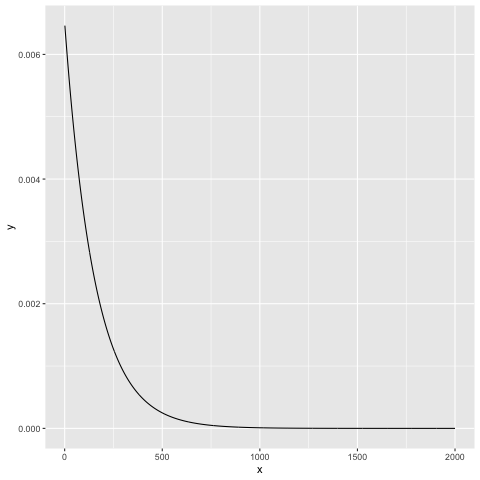

In [115]:
%%R -i p_V3 -i p_V0

x = 1:2000
y = dgeom(x, 1-p_V3)

ggplot() +
    geom_line(aes(x, y))

In [160]:
%%R

len = 54009300-54002500
print(len)

print(1-pgeom(len, 1-p_V3))

print(qgeom(c(0.25, 0.5, 0.75, 0.99, 0.9999), 1-p_V3))

# Probability that X > len
print(p_V3^(6800+1))

# Probability that X >= len
p_V3^(6800)

[1] 6800
[1] 0
[1]   44  106  212  705 1411
[1] 5.325893e-20
[1] 5.36076e-20


In [225]:
%%R -w 2000 -h 300 -r 150

idx = 194

print(idx)

df_p1 <- read_csv(paste0('tmp/test_', idx, '_p1.csv')) 

df_mod_p1 <- df_p1 %>%
    filter(position != -9) %>%
    filter(between(position, 71290000, 71370000)) %>%
    pivot_longer(-position) %>%
    separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
    mutate(
        topology = as.integer(topology),
        int_1 = as.integer(int_1),
        int_2 = as.integer(int_2),
        is_V0 = topology == 0
    )

df_p2 <- read_csv(paste0('tmp/test_', idx, '_p2.csv'))

df_mod_p2 <- df_p2 %>%
    filter(position != -9) %>%
    filter(between(position, 71290000, 71370000)) %>%
    pivot_longer(-position) %>%
    separate_wider_delim(name, ', ', names = c('topology', 'int_1', 'int_2')) %>%
    mutate(
        topology = as.integer(topology),
        int_1 = as.integer(int_1),
        int_2 = as.integer(int_2),
        is_V0 = topology == 0
    )
    
p1 <- df_mod_p1 %>%
    group_by(position, is_V0, int_1) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)) +
    geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno"
                            ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))), 
        # labels = c(0:(n_int_AB-1), 0:(n_int_ABC_1-1)),
        labels = paste0('F', c(0:(n_int_AB+n_int_ABC-1))),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    theme(
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    ) +
    labs(y = 'First coalescent', x = 'Position')

p2 <- df_mod_p2 %>%
    group_by(position, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, int_2, fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, int_2, fill = prob, color = prob)) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = 0:(n_int_ABC-1), 
        # labels = 0:(n_int_ABC_2-1),
        labels = paste0('S', 0:(n_int_ABC-1)),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    labs(y = 'Second coalescent') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    )

p3 <- df_mod_p1 %>%
    group_by(position, topology) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    # rasterize(geom_tile(aes(position, topology, fill = prob, color = prob)), dpi = 300) +
    geom_tile(aes(position, topology, fill = prob, color = prob)) +
    # geom_vline(aes(xintercept = x), color = 'green', data = tibble(x = c(54002500, 54009300))) +
    theme_few() +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                            limits = c(0, 1),
                            option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0, 1, 2, 3), 
        labels = c('V0', 'V1', 'V2', 'V3'),
        expand = c(0, 0),
        # sec.axis = dup_axis()
    ) +
    labs(y = 'Topology') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y.right = element_blank(),
        text = element_text(size = 12)
    )








limits <- c(min(df_mod_p1$position), max(df_mod_p1$position))

# tr_tab <- read_tsv('./tmp/table_120.tsv',
#     col_types = c('ccciiiiicccc')
# ) 

# colnames(tr_tab) <- str_remove_all(colnames(tr_tab), 'hg38.knownGene.')
    
# exon_tab <- tr_tab %>%
#     group_by(`#name`, chrom, strand, txStart,  txEnd, cdsStart, cdsEnd, exonCount, proteinID, alignID) %>%
#     summarize(
#         exonStarts = unlist(str_split(exonStarts, ',')),
#         exonEnds = unlist(str_split(exonEnds, ','))
#     ) %>%
#     filter(exonStarts != '') %>%
#     mutate(
#         exonStarts = as.integer(exonStarts),
#         exonEnds = as.integer(exonEnds)
#     )

# reg_tab_1 <- exon_tab %>%
#     filter(exonStarts == min(exonStarts))
# reg_tab_2 <- exon_tab %>%
#     filter(exonStarts == max(exonStarts))

# exon_tab <- exon_tab %>%
#     mutate(
#         exonStarts = ifelse(exonStarts == min(exonStarts), cdsStart, exonStarts)
#     )

# p_genes <- exon_tab %>%
#     ggplot() +
#     geom_segment(aes(x = cdsStart, xend = cdsEnd, y = 0.5, yend = 0.5)) +
#     geom_rect(aes(xmin = exonStarts, xmax = exonEnds, ymin = 0, ymax = 1), color = 'black', fill = 'black') +
#     geom_rect(aes(xmin = exonStarts, xmax = cdsStart, ymin = 0, ymax = 1), color = 'black', fill = 'white', data = reg_tab_1) +
#     geom_rect(aes(xmin = exonEnds, xmax = cdsEnd, ymin = 0, ymax = 1), color = 'black', fill = 'white', data = reg_tab_2) +
#     scale_x_continuous(limits = limits, expand = c(0, 0)) +
#     scale_y_continuous(limits = c(0, 1.6)) +
#     geom_segment(aes(x = exonEnds, xend = exonEnds-2000, y = 1.3, yend = 1.3), arrow = arrow(length = unit(0.3, "npc")), data = reg_tab_2) +
#     geom_segment(aes(x = exonEnds, xend = exonEnds, y = 1, yend = 1.3), data = reg_tab_2) +
#     geom_text(aes(x = exonEnds+300, y = 0.5, label = "italic('LDLRAD1')"), parse = TRUE, size = 3, hjust = 0, data = reg_tab_2) +
#     theme_void()


# LDLRAD1


fac = 0.7


plt_tot <- (p3+p2+p1 + 
      plot_layout(ncol = 1, heights = c(4, n_int_ABC, n_int_AB+n_int_ABC), guides = 'collect')) 
      # & theme(legend.position = 'none')
    
ggsave(paste0('./tmp/tmp_', idx, '_region_with_genes.tiff'), plt_tot, width = 14*fac, height = 10*fac)

[1] 194
Rows: 221410 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 221410 Columns: 71
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (71): 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 4, 0, 1, 0, 0, 1, 1, 0, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'position', 'is_V0'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'position'. You can override using the
`.grou